## 1. Data preprocess
### 1.1. From nc to npy
Load the nc files and translate the format into npy array.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.listdir('/content/drive/MyDrive/2030/datasets')

['tie_meteo.nc',
 'Oa14_radiance_unc.nc',
 'Oa10_radiance_unc.nc',
 'Oa17_radiance.nc',
 'Oa11_radiance_unc.nc',
 'Oa15_radiance.nc',
 'Oa11_radiance.nc',
 'Oa20_radiance_unc.nc',
 'Oa02_radiance.nc',
 'Oa10_radiance.nc',
 'geo_coordinates.nc',
 'Oa16_radiance.nc',
 'Oa19_radiance.nc',
 'qualityFlags.nc',
 'Oa16_radiance_unc.nc',
 'Oa01_radiance_unc.nc',
 'Oa07_radiance_unc.nc',
 'Oa08_radiance_unc.nc',
 'Oa13_radiance.nc',
 'Oa20_radiance.nc',
 'Oa14_radiance.nc',
 'Oa21_radiance_unc.nc',
 'Oa19_radiance_unc.nc',
 'Oa21_radiance.nc',
 'Oa18_radiance.nc',
 'xfdumanifest.xml',
 'Oa12_radiance.nc',
 'tie_geo_coordinates.nc',
 'Oa03_radiance.nc',
 'Oa13_radiance_unc.nc',
 'Oa07_radiance.nc',
 'Oa09_radiance.nc',
 'quicklook.jpg',
 'tie_geometries.nc',
 'Oa05_radiance.nc',
 'Oa12_radiance_unc.nc',
 'instrument_data.nc',
 'Oa09_radiance_unc.nc',
 'Oa04_radiance_unc.nc',
 'time_coordinates.nc',
 'Oa18_radiance_unc.nc',
 'Oa08_radiance.nc',
 'Oa01_radiance.nc',
 'Oa03_radiance_unc.nc',
 'Oa06

In [ ]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00


In [ ]:
# -*- coding: utf-8 -*-
import os
import numpy as np
from netCDF4 import Dataset


# Directory with `Oa*_radiance.nc`, `mask1.png`, `config1.json`, `mask2.png`, `config2.json`
data_path = '/content/drive/MyDrive/2030/datasets'
save_path = '/content/drive/MyDrive/2030/datasets'

# Load a single nc file and translate to npy
def nc2npy(path):
    nc = Dataset(path)
    nc = nc.variables[path.split('/')[-1].replace('.nc', '')]
    nc = np.array(nc)
    nc[np.where(nc == 65535)] = 0

    return nc

# Load and concatenate all nc files
res = []
for i in range(1,22):
    arr = nc2npy(os.path.join(data_path, "Oa%02d_radiance.nc"%(i)))
    res.append(arr)

res = np.stack(res, axis=-1)
print(res.shape)

# Save the result
np.save(os.path.join(save_path, "radiance.npy"), res)


(4090, 4865, 21)


Load the preprocessed npy array and parse the annotations, then crop the original image into multiple 9x9 crops.

In [ ]:
# Directory with `Oa*_radiance.nc`, `mask1.png`, `config1.json`, `mask2.png`, `config2.json`
data_path = '/content/drive/MyDrive/2030/datasets'
save_path = '/content/drive/MyDrive/2030/datasets'


In [ ]:
# Import all packages needed
import os
import numpy as np
import cv2
import json
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import image


input_size = 9

def load_labels(mask_path, cfg_path):
    with open(cfg_path, 'r') as f:
        cfg = json.load(f)

    # Load colors from config
    mask_bbox = cfg['segmentation']['mask_area']
    class_info = cfg['classes'][1:]
    colors = [c['colour'][:3] for c in class_info]

    # Parse the color to classes
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    mask_labels = np.zeros(mask.shape[:2])
    for idx, c in enumerate(colors):
        mask_labels[(mask[:,:,0]==c[0]) & (mask[:,:,1]==c[1]) & (mask[:,:,2]==c[2])] = idx

    # Trim the mask to exclude boundary labels
    margin = input_size // 2
    trimmed_mask = mask_labels[margin:-margin, margin:-margin]

    # Flatten the trimmed mask to get a 1D array of labels
    labels = trimmed_mask.flatten()

    # Return bbox to crop images
    return labels, mask_bbox

# Load preprocessed features
bands = np.load(os.path.join(data_path, "radiance.npy"))

# Normalize the features
nx, ny = bands.shape[0] - 2, bands.shape[1] - 2
norm_mean = bands.reshape(-1, 21).mean()
norm_std = bands.reshape(-1, 21).std()
bands = (bands - norm_mean) / norm_std

# Load labels
labels, mask_bbox = load_labels(os.path.join(data_path, "mask1.png"),\
    os.path.join(data_path, "config1.json"))

# roi is with shape (1500, 1400, 21)
x1, y1, x2, y2 = mask_bbox
roi = bands[y1:y2, x1:x2]

# Extract patches of size 3x3 from the TOA BRF and reshape for further processing
patches = image.extract_patches_2d(roi, (input_size, input_size))

print(patches.shape)
print(labels.shape)

(2076864, 9, 9, 21)
(2076864,)


### 1.2. Split and resampling
Split the train and validation subsets, and resample a balanced dataset.

In [ ]:
# Initially, we examine the quantity of each class present in the dataset
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# Identifying the class with the smaller count to balance the number in each class
num_class = min(counts) # Adjust it to the amount you get

# Extract indices of both classes
indices_class_0 = np.where(labels == 0)[0]
indices_class_1 = np.where(labels == 1)[0]

# Random sampling from each
sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)
sampled_indices_class_1 = np.random.choice(indices_class_1, num_class, replace=False)

# Combine the sampled indices
combined_indices = np.concatenate([sampled_indices_class_0, sampled_indices_class_1])

# Extract the corresponding patches and labels
balanced_patches = patches[combined_indices]
balanced_labels = labels[combined_indices]


# Split the balanced dataset into training and testing sets with a 1:9 ratio
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    balanced_patches, balanced_labels, test_size=0.1, random_state=42
)

# Check the balance in y_train_balanced
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))

# Save the results
np.save(os.path.join(data_path, 'X_train_balanced.npy'), X_train_balanced)
np.save(os.path.join(data_path, 'X_test_balanced.npy'), X_test_balanced)
np.save(os.path.join(data_path, 'y_train_balanced.npy'), y_train_balanced)
np.save(os.path.join(data_path, 'y_test_balanced.npy'), y_test_balanced)

{0.0: 645911, 1.0: 1430953}
{0.0: 581409, 1.0: 581230}


In [ ]:
import os
import numpy as np

X_train = np.load(os.path.join(data_path, 'X_train_balanced.npy'))
X_test = np.load(os.path.join(data_path, 'X_test_balanced.npy'))
y_train = np.load(os.path.join(data_path, 'y_train_balanced.npy'))
y_test = np.load(os.path.join(data_path, 'y_test_balanced.npy'))

## 2. Model training
Import tensorflow and config the devices.

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15820196924703093999
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40427651072
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11988428769573397337
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


In [ ]:
!pip install tensorflow-addons

In [ ]:
# Install packages needed
import warnings
warnings.filterwarnings('ignore')

import gc
import numpy as np
np.object = np.object_
np.bool = np.bool_
np.int = np.int_
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_addons as tfa


os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4"
print('cuda available:',tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

cuda available: True
Num GPUs Available:  1


### 2.1. ViT
Define key classes to build the ViT model.

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def create_vit_classifier(input_shape, patch_size, num_patches, projection_dim):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = more_data(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

def run_experiment(model, batch_size, num_epochs, learning_rate, weight_decay):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

# Data augmentation
more_data = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(input_size, input_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="more_data",
)
more_data.layers[0].adapt(X_train)

Main training processing. It takes about 20 min in a single RTX 4090 GPU.

In [ ]:
num_classes = 2 # Can be changed to multi-classed classification
patch_size = 3
input_shape = (input_size, input_size, 21)
num_patches = (input_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]

batch_size = 64
num_epochs = 1
learning_rate = 0.001
weight_decay = 0.0001

# Here vit is your trained model after the training
vit = create_vit_classifier(input_shape, patch_size, num_patches, projection_dim)
history = run_experiment(vit, batch_size, num_epochs, learning_rate, weight_decay)

vit.save(data_path+"vit_model.tf")

tf.keras.backend.clear_session()
del vit
gc.collect()

4037/4037 [==============================] - 53s 13ms/step - loss: 0.0353 - accuracy: 0.9875 - top-5-accuracy: 1.0000
Test accuracy: 98.75%


143541

### 2.2. CNN

In [ ]:
import os
os.chdir('/content/drive/MyDrive/2030')

In [ ]:
num_classes = 2 # Can be changed to multi-classed classification
input_shape = (input_size, input_size, 21)
output_dim = [32,64,64]
batch_size = 64
num_epochs = 3
learning_rate = 0.001
weight_decay = 0.0001


# Define the model
cnn = models.Sequential()
in_dim = input_shape[-1]
for out_dim in output_dim:
    cnn.add(layers.Conv2D(out_dim, (3, 3), activation='relu', input_shape=(input_size, input_size, in_dim), padding='SAME'))
    in_dim = out_dim

cnn.add(layers.MaxPooling2D((3, 3)))

# Add dense layers for classification
cnn.add(layers.Flatten())
cnn.add(layers.Dense(output_dim[-1], activation='relu'))
cnn.add(layers.Dense(num_classes, activation='softmax'))

history = run_experiment(cnn, batch_size, num_epochs, learning_rate, weight_decay)
cnn.save("cnn_model.tf")

tf.keras.backend.clear_session()
del cnn
gc.collect()

Epoch 1/3
16350/16350 [==============================] - 64s 4ms/step - loss: 0.0550 - accuracy: 0.9821 - top-5-accuracy: 1.0000 - val_loss: 0.0382 - val_accuracy: 0.9887 - val_top-5-accuracy: 1.0000
Epoch 2/3
16350/16350 [==============================] - 62s 4ms/step - loss: 0.0437 - accuracy: 0.9860 - top-5-accuracy: 1.0000 - val_loss: 0.0401 - val_accuracy: 0.9871 - val_top-5-accuracy: 1.0000
Epoch 3/3
4037/4037 [==============================] - 10s 2ms/step - loss: 0.0389 - accuracy: 0.9882 - top-5-accuracy: 1.0000
Test accuracy: 98.82%


102600

### 2.3. Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# Initialise the model with n_estimators specifying the number of trees in the forest
rf = RandomForestClassifier(n_estimators=32, n_jobs=32, max_depth=16)

# We need to reshape the data in order to be compatible with Random Forest
X_reshaped = np.reshape(X_train, (X_train.shape[0], -1))

# Fit the model to your training data
rf.fit(X_reshaped, y_train)
joblib.dump(rf, "random_forest_model.tf")

['random_forest_model.tf']

In [ ]:
from sklearn.linear_model import LogisticRegression
import joblib

# Initialise the model with n_estimators specifying the number of trees in the forest
lr = LogisticRegression(n_jobs=32)

# We need to reshape the data in order to be compatible with Random Forest
X_reshaped = np.reshape(X_train, (X_train.shape[0], -1))

# Fit the model to your training data
lr.fit(X_reshaped, y_train)
joblib.dump(lr, "linear_regression_model.tf")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


['linear_regression_model.tf']

## 3. Inference and evaluation
### 3.1. Quantitative results
Infer the results in another area, evalute the metrics, and save the visualization results.

In [ ]:
# Import all packages needed
import numpy as np
import cv2
import json
import gc
from matplotlib import pyplot as plt
from sklearn.feature_extraction import image


input_size = 9
data_path = '/content/drive/MyDrive/2030/datasets'

def load_labels(mask_path, cfg_path):
    with open(cfg_path, 'r') as f:
        cfg = json.load(f)

    # Load colors from config
    mask_bbox = cfg['segmentation']['mask_area']
    class_info = cfg['classes'][1:]
    colors = [c['colour'][:3] for c in class_info]

    # Parse the color to classes
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    mask_labels = np.zeros(mask.shape[:2])
    for idx, c in enumerate(colors):
        mask_labels[(mask[:,:,0]==c[0]) & (mask[:,:,1]==c[1]) & (mask[:,:,2]==c[2])] = idx

    # Trim the mask to exclude boundary labels
    margin = input_size // 2
    trimmed_mask = mask_labels[margin:-margin, margin:-margin]

    # Flatten the trimmed mask to get a 1D array of labels
    labels = trimmed_mask.flatten()

    # Return bbox to crop images
    return labels, mask_bbox


In [ ]:
# Install packages needed
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
np.object = np.object_
np.bool = np.bool_
np.int = np.int_
import tensorflow as tf


os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4"
print('cuda available:',tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

cuda available: True
Num GPUs Available:  0


In [ ]:
def predict_deep(checkpoint, x_test):
    # Make predictions on the roi
    model = tf.keras.models.load_model(checkpoint, compile=False)
    print("Running prediction...")
    y_logit = []
    max_number_samples = int(1e6)
    while len(x_test) > 0:
        y_logit.append(model.predict(x_test[:max_number_samples], batch_size=65535))
        x_test = x_test[max_number_samples:]

        tf.keras.backend.clear_session()
        gc.collect()

        # print(len(y_logit), x_test.shape)
    y_logit = np.concatenate(y_logit, 0)

    # y_logit = model.predict(x_test, batch_size=65535)
    del model
    gc.collect()
    print("Done.")

    y_pred = np.argmax(y_logit, axis=1)
    return y_pred

def predict_traditional(checkpoint, x_test):
    # Predict the classes of the test data
    model = joblib.load(checkpoint)
    x_test_reshaped = np.reshape(x_test, (x_test.shape[0], -1))
    y_pred = model.predict(x_test_reshaped)
    del model
    gc.collect()
    return y_pred

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


(2273544, 9, 9, 21) (2273544,)
Running prediction...
5/5 [==============================] - 2s 349ms/step
Done.
============ Results of vit ============
              precision    recall  f1-score   support

       Ocean       1.00      0.87      0.93   1028382
       Cloud       0.91      1.00      0.95   1245162

    accuracy                           0.94   2273544
   macro avg       0.95      0.94      0.94   2273544
weighted avg       0.95      0.94      0.94   2273544



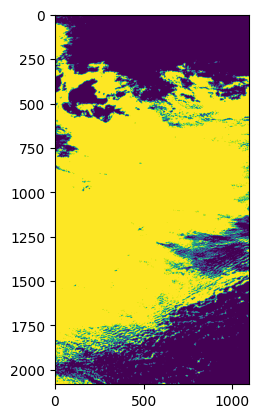

Running prediction...
5/5 [==============================] - 1s 229ms/step
Done.
============ Results of cnn ============
              precision    recall  f1-score   support

       Ocean       1.00      0.83      0.91   1028382
       Cloud       0.88      1.00      0.94   1245162

    accuracy                           0.92   2273544
   macro avg       0.94      0.92      0.92   2273544
weighted avg       0.93      0.92      0.92   2273544



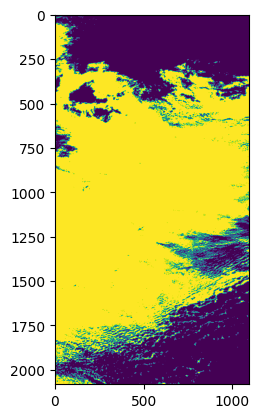

============ Results of random_forest ============
              precision    recall  f1-score   support

       Ocean       1.00      0.87      0.93   1028382
       Cloud       0.90      1.00      0.95   1245162

    accuracy                           0.94   2273544
   macro avg       0.95      0.93      0.94   2273544
weighted avg       0.95      0.94      0.94   2273544



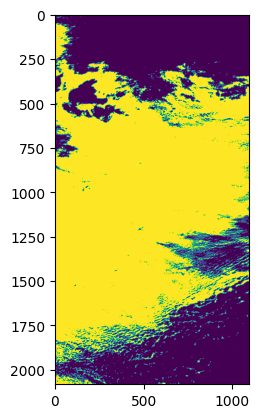

In [ ]:
import joblib
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_addons as tfa

labels_test, mask_bbox_test = load_labels(os.path.join(data_path, "mask2.png"),\
    os.path.join(data_path, "config2.json"))
labels_test = labels_test.astype(np.int8)
x1, y1, x2, y2 = mask_bbox_test


# Load preprocessed features
bands = np.load(os.path.join(data_path, "radiance.npy"))

# Normalize the features
nx, ny = bands.shape[0] - 2, bands.shape[1] - 2
norm_mean = bands.reshape(-1, 21).mean()
norm_std = bands.reshape(-1, 21).std()
bands = (bands - norm_mean) / norm_std
roi_test = bands[y1:y2, x1:x2]

# Extract patches of size 9x9 from the TOA BRF and reshape for further processing
x_test_mask2 = image.extract_patches_2d(roi_test, (input_size, input_size))
print(x_test_mask2.shape, labels_test.shape)

models = ["vit", "cnn", "random_forest", "linear_regression"]
for model in models:
    pred_fn = predict_deep if model in ["vit", "cnn"] else predict_traditional
    y_pred = pred_fn(model + '_model.tf', x_test_mask2)

    # Evaluation
    print("============ Results of %s ============"%model)
    print(classification_report(labels_test, y_pred, target_names=["Ocean", "Cloud"]))

    # Reshape it for display
    margin = input_size // 2
    y_pred = y_pred.reshape(y2 - y1 - 2*margin, x2 - x1 - 2*margin)

    # Save the predicted map
    plt.imsave('pred_mask2_%s.png'%model, (y_pred*255).astype(np.uint8))
    plt.cla()
    plt.imshow((y_pred*255).astype(np.uint8))
    plt.show()


(2273544, 9, 9, 21) (2273544,)
============ Results of linear_regression ============
              precision    recall  f1-score   support

       Ocean       1.00      0.86      0.93   1028382
       Cloud       0.90      1.00      0.95   1245162

    accuracy                           0.94   2273544
   macro avg       0.95      0.93      0.94   2273544
weighted avg       0.94      0.94      0.94   2273544



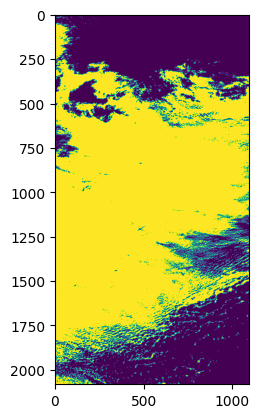

In [ ]:
import joblib
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_addons as tfa
import os
os.chdir('/content/drive/MyDrive/2030')
labels_test, mask_bbox_test = load_labels(os.path.join(data_path, "mask2.png"),\
    os.path.join(data_path, "config2.json"))
labels_test = labels_test.astype(np.int8)
x1, y1, x2, y2 = mask_bbox_test


# Load preprocessed features
bands = np.load(os.path.join(data_path, "radiance.npy"))

# Normalize the features
nx, ny = bands.shape[0] - 2, bands.shape[1] - 2
norm_mean = bands.reshape(-1, 21).mean()
norm_std = bands.reshape(-1, 21).std()
bands = (bands - norm_mean) / norm_std
roi_test = bands[y1:y2, x1:x2]

# Extract patches of size 9x9 from the TOA BRF and reshape for further processing
x_test_mask2 = image.extract_patches_2d(roi_test, (input_size, input_size))
print(x_test_mask2.shape, labels_test.shape)

models = ["linear_regression"]
for model in models:
    pred_fn = predict_deep if model in ["vit", "cnn"] else predict_traditional
    y_pred = pred_fn(model + '_model.tf', x_test_mask2)

    # Evaluation
    print("============ Results of %s ============"%model)
    print(classification_report(labels_test, y_pred, target_names=["Ocean", "Cloud"]))

    # Reshape it for display
    margin = input_size // 2
    y_pred = y_pred.reshape(y2 - y1 - 2*margin, x2 - x1 - 2*margin)

    # Save the predicted map
    plt.imsave('pred_mask2_%s.png'%model, (y_pred*255).astype(np.uint8))
    plt.cla()
    plt.imshow((y_pred*255).astype(np.uint8))
    plt.show()


### 3.2. Explainable AI

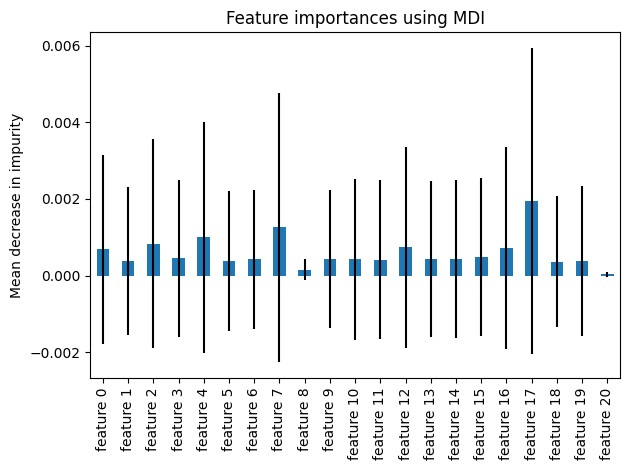

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

import os

os.chdir('/content/drive/MyDrive/2030')

input_size = 9

forest = joblib.load("random_forest_model.tf")
importances = forest.feature_importances_
importances = importances.reshape(input_size**2,21).mean(0)
std = np.std([tree.feature_importances_.reshape(input_size**2,21).mean(0) for tree in forest.estimators_], axis=0)

feature_names = [f"feature {i}" for i in range(len(importances))]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Testing sensitivity for model 0...
Epoch 1/3
16350/16350 [==============================] - 68s 4ms/step - loss: 0.0508 - accuracy: 0.9836 - val_loss: 0.0323 - val_accuracy: 0.9899
Epoch 2/3
16350/16350 [==============================] - 66s 4ms/step - loss: 0.0345 - accuracy: 0.9888 - val_loss: 0.0307 - val_accuracy: 0.9893
Epoch 3/3
1/1 [==============================] - 0s 78ms/step
Testing sensitivity for model 1...
Epoch 1/3
16350/16350 [==============================] - 68s 4ms/step - loss: 0.0509 - accuracy: 0.9833 - val_loss: 0.0321 - val_accuracy: 0.9897
Epoch 2/3
16350/16350 [==============================] - 65s 4ms/step - loss: 0.0331 - accuracy: 0.9885 - val_loss: 0.0321 - val_accuracy: 0.9881
Epoch 3/3
1/1 [==============================] - 0s 74ms/step
Testing sensitivity for model 2...
Epoch 1/3
16350/16350 [==============================] - 68s 4ms/step - loss: 0.0500 - accuracy: 0.9838 - val_loss: 0.0368 - val_accuracy: 0.9882
Epoch 2/3
16350/16350 [==================

1/1 [==============================] - 0s 76ms/step
Testing sensitivity for model 4...
Epoch 1/3
16350/16350 [==============================] - 68s 4ms/step - loss: 0.0523 - accuracy: 0.9828 - val_loss: 0.0307 - val_accuracy: 0.9899
Epoch 2/3
16350/16350 [==============================] - 65s 4ms/step - loss: 0.0334 - accuracy: 0.9887 - val_loss: 0.0312 - val_accuracy: 0.9890
Epoch 3/3
16350/16350 [==============================] - 65s 4ms/step - loss: 0.0290 - accuracy: 0.9896 - val_loss: 0.0244 - val_accuracy: 0.9905


1/1 [==============================] - 0s 74ms/step


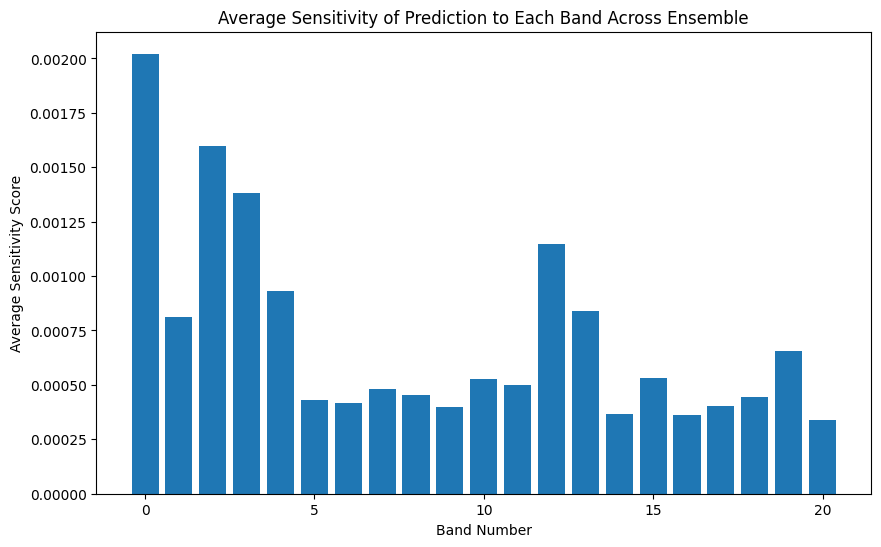

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import gc


data_path = '/content/drive/MyDrive/2030/datasets'

# Define the CNN model architecture as a function for reusability
def create_model(input_shape):
    output_dim = [32,64,64]
    cnn = models.Sequential()
    in_dim = input_shape[-1]
    for out_dim in output_dim:
        cnn.add(layers.Conv2D(out_dim, (3, 3), activation='relu', input_shape=(input_size, input_size, in_dim), padding='SAME'))
        in_dim = out_dim

    cnn.add(layers.MaxPooling2D((3, 3)))

    # Add dense layers for classification
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(output_dim[-1], activation='relu'))
    cnn.add(layers.Dense(2, activation='softmax'))

    return cnn

# Sensitivity analysis function remains the same
def sensitivity_analysis(model, input_image, class_idx):
    input_image_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)  # Convert to TensorFlow tensor
    with tf.GradientTape() as tape:
        tape.watch(input_image_tensor)
        predictions = model(input_image_tensor, training=False)
        class_output = predictions[:, class_idx]

    gradients = tape.gradient(class_output, input_image_tensor)
    band_sensitivity = tf.reduce_sum(tf.abs(gradients), axis=(1, 2))
    return band_sensitivity.numpy()


X_train = np.load(os.path.join(data_path, 'X_train_balanced.npy'))
X_test = np.load(os.path.join(data_path, 'X_test_balanced.npy'))
y_train = np.load(os.path.join(data_path, 'y_train_balanced.npy'))
y_test = np.load(os.path.join(data_path, 'y_test_balanced.npy'))

# Ensemble approach: Train multiple models and compute average sensitivity
num_models = 5  # Number of models in the ensemble
ensemble_sensitivities = []

for i in range(num_models):
    print("Testing sensitivity for model %d..."%i)
    # Create and compile a new model instance
    model = create_model(X_train.shape[1:])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Fit the model
    model.fit(X_train, y_train, epochs=3, validation_split=0.1, batch_size=64)

    # Perform sensitivity analysis on a sample image for each model
    sample_image = X_test[:1]  # Use the first image in X_test as a sample
    predictions = model.predict(sample_image)
    class_idx = np.argmax(predictions[0])  # Class of interest

    band_sensitivity = sensitivity_analysis(model, sample_image, class_idx)
    ensemble_sensitivities.append(band_sensitivity)

    tf.keras.backend.clear_session()
    del model
    gc.collect()

# Average the sensitivity scores across all models
average_sensitivity = np.mean(ensemble_sensitivities, axis=0)

# Visualize the average sensitivity scores
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[3]), average_sensitivity[0])
plt.xlabel('Band Number')
plt.ylabel('Average Sensitivity Score')
plt.title('Average Sensitivity of Prediction to Each Band Across Ensemble')
plt.show()